<a href="https://colab.research.google.com/github/spentaur/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# predict property sales prices for One Family Dwellings `(BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS')` using a subset of the data where the `sale price was more than $100 thousand and less than $2 million`.

# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

january = '2019-01-01'
march = '2019-03-31'
april = '2019-04-30'


train_conditions = ((df['SALE_DATE'] >= january) & 
                    (df['SALE_DATE'] < april))

test_conditions = (df['SALE_DATE'] == april)

conditions = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
                  (df['SALE_PRICE'] > 100000) & 
                  (df['SALE_PRICE'] < 2000000))



train = df[conditions & train_conditions].copy()
test = df[conditions & test_conditions].copy()

In [0]:
train = train.dropna(thresh=len(train)*0.6,axis=1)
test = test.dropna(thresh=len(test)*0.6,axis=1)

In [119]:
test['SALE_DATE'].describe()

count                      26
unique                      1
top       2019-04-30 00:00:00
freq                       26
first     2019-04-30 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [120]:
train['SALE_DATE'].describe()

count                    3125
unique                     90
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-29 00:00:00
Name: SALE_DATE, dtype: object

In [121]:
train['BUILDING_CLASS_CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS    3125
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [122]:
train['SALE_PRICE'].min()

104000

In [123]:
train['SALE_PRICE'].max()

1955000

# Do exploratory visualizations with Seaborn.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

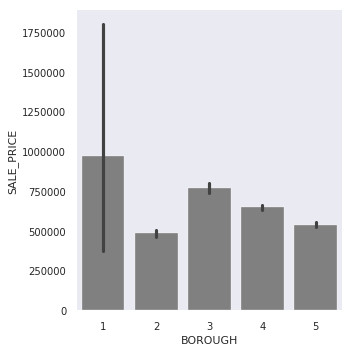

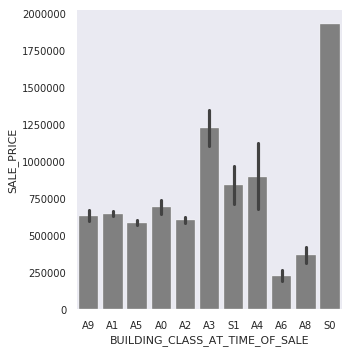

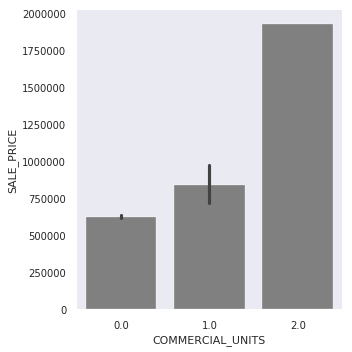

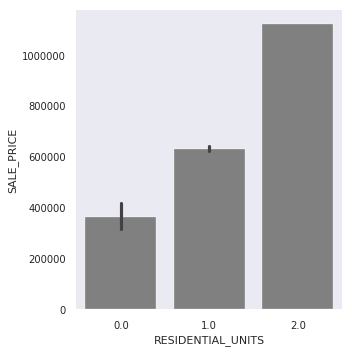

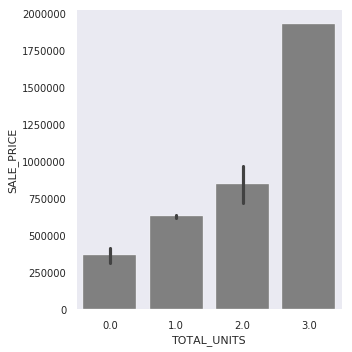

In [125]:
sns.set_style('dark')

for col in sorted(train.columns):
    if 2 < train[col].nunique() < 12:
        sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
        plt.show()

# Do one-hot encoding of categorical features.

In [126]:
train.select_dtypes('object').columns

Index(['NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'LAND_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
cats = ['NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE']

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
train_encoded = encoder.fit_transform(train[cats])
test_encoded = encoder.transform(test[cats])

In [129]:
train.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [0]:
# drop the cats from test / train and add the endocded ones instead

test = test.drop(cats, axis=1)
train = train.drop(cats, axis=1)

test = pd.concat([test, test_encoded], axis=1, sort=False)
train = pd.concat([train, train_encoded], axis=1, sort=False)

# Do feature selection with SelectKBest.

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
features = train.select_dtypes(include=['number', 'bool']).columns.drop('SALE_PRICE')

In [134]:
kbest = SelectKBest(score_func=f_regression, k = 20)
train_selected = kbest.fit_transform(train[features], train['SALE_PRICE'])

train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(3125, 20)

In [137]:
selected_mask = kbest.get_support()
selected_features = features[selected_mask]
unselected_features = features[~selected_mask]

print('Features selected:')
for num, name in enumerate(selected_features):
    print(num + 1, name)

Features selected:
1 BLOCK
2 ZIP_CODE
3 RESIDENTIAL_UNITS
4 COMMERCIAL_UNITS
5 TOTAL_UNITS
6 GROSS_SQUARE_FEET
7 NEIGHBORHOOD_MADISON
8 NEIGHBORHOOD_MIDWOOD
9 NEIGHBORHOOD_BAYSIDE
10 NEIGHBORHOOD_FLUSHING-NORTH
11 NEIGHBORHOOD_FOREST HILLS
12 NEIGHBORHOOD_WHITESTONE
13 NEIGHBORHOOD_BAY RIDGE
14 NEIGHBORHOOD_BOROUGH PARK
15 NEIGHBORHOOD_SUNSET PARK
16 NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN
17 TAX_CLASS_AT_PRESENT_1
18 BUILDING_CLASS_AT_PRESENT_A3
19 BUILDING_CLASS_AT_TIME_OF_SALE_A3
20 BUILDING_CLASS_AT_TIME_OF_SALE_A8


In [138]:
selected_features

Index(['BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'NEIGHBORHOOD_MADISON',
       'NEIGHBORHOOD_MIDWOOD', 'NEIGHBORHOOD_BAYSIDE',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_WHITESTONE', 'NEIGHBORHOOD_BAY RIDGE',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_SUNSET PARK',
       'NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN', 'TAX_CLASS_AT_PRESENT_1',
       'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8'],
      dtype='object')

# Fit a linear regression model with multiple features.

In [139]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(train[selected_features], train['SALE_PRICE'])



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Get mean absolute error for the test set.

In [0]:
from sklearn.metrics import mean_absolute_error

test_pred = model.predict(test[selected_features])

In [146]:
mean_absolute_error(test['SALE_PRICE'], test_pred)

164204.30573362342

In [150]:
(mean_absolute_error(test['SALE_PRICE'], test_pred) / df['SALE_PRICE'].mean()) * 100

12.363547971937699